<center><h1>Mapping the emotional face. How individual face parts contribute to successful emotion recognition.</h1></center>

# 4a. Plotting Results by Action Units

This notebook aggregates the tiles in accordance to the Ekman Action Units (AUs) they fall into.  

The AUs have been manually defined on each individual face and each AU has a color code that identifies it.
Now, the algorithm assigns each tile one or a number of AUs that are contained in it, so each tile has either an AU label, or it represents no AU.

### importing the basic modules and files

In [1]:
from myBasics import *
%matplotlib inline

In [2]:
logList = getFile('../rawTables/','pand*.csv')

## Visualize the hand-drawn Action Units (AUs)

#### Example:  
Get all the AUs for one picture. This is a list of single images, one per AU, where each AU is drawn in a different color.

In [3]:
myPicList = getFile('../auLabels/','f_ang*.png')

Now we have an array with all AU's that belong to the female angry face (f_ang):

In [4]:
myPicList

['../auLabels/f_ang_AU22+23+25.png',
 '../auLabels/f_ang_AU6.png',
 '../auLabels/f_ang_AU7.png',
 '../auLabels/f_ang_AU9.png']

For illustration purposes, here we plot all the hand-drawn AU's of that face

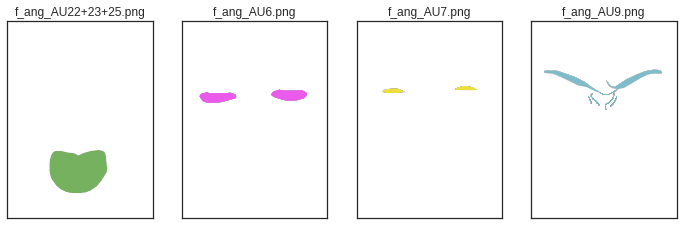

In [5]:
fig = plt.figure(figsize=(12,4))
for i,pic in enumerate(myPicList):
    im = Image.open(pic)
    ax = plt.subplot(1,len(myPicList),i+1)
    ax.set_title(pic[pic.rfind('/')+1:],fontsize=12)
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(im);

### Simple visualisation of all AUs on the faces

In [6]:
myPaintList =  []
for fGender in ['f','m']:
    thisList = []
    for fEmo in myLabels.values()[:-1]:
        thisFace = getFile('../auLabels/auVisualisation/',fGender+'_'+fEmo+'*.png')[-1]
        thisList.append(thisFace)
    myPaintList.append(thisList) 

In [7]:
myPaintList

[['../auLabels/auVisualisation/f_hap_w_cut.png',
  '../auLabels/auVisualisation/f_sad_w_cut.png',
  '../auLabels/auVisualisation/f_ang_w_cut.png',
  '../auLabels/auVisualisation/f_fea_w_cut.png',
  '../auLabels/auVisualisation/f_dis_w_cut.png',
  '../auLabels/auVisualisation/f_sup_w_cut.png'],
 ['../auLabels/auVisualisation/m_hap_m_cut.png',
  '../auLabels/auVisualisation/m_sad_m_cut.png',
  '../auLabels/auVisualisation/m_ang_m_cut.png',
  '../auLabels/auVisualisation/m_fea_m_cut.png',
  '../auLabels/auVisualisation/m_dis_m_cut.png',
  '../auLabels/auVisualisation/m_sup_m_cut.png']]

In [8]:
def makePicturePlot(myPaintList):
    
    fig = plt.figure( figsize=(16,8) )
    i = 1 # counter for subplots
    for ident in range(2):
        for emo in range(6):

            im=Image.open(myPaintList[ident][emo],'r')

            ax = plt.subplot(2,6,i)
            ax.imshow(im)
            ax.set_yticks([]); ax.set_xticks([])

            i+=1
    plt.savefig('../figures/auIllustration.png',dpi=300)
    plt.show()

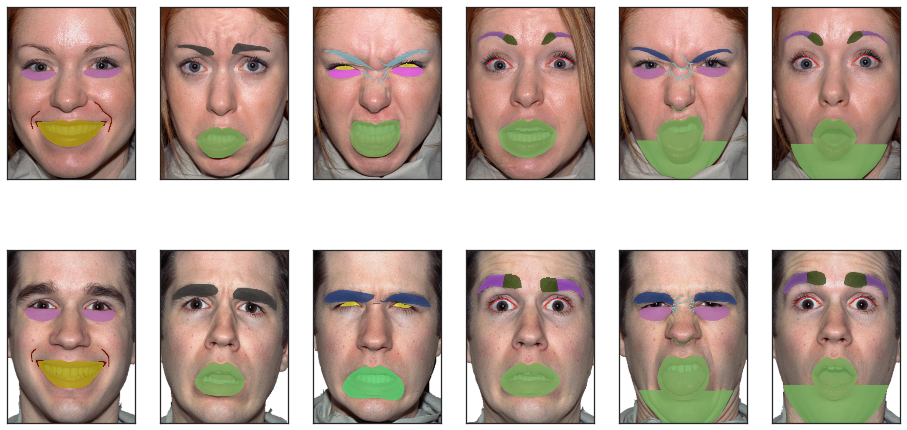

In [9]:
makePicturePlot(myPaintList)

## Assign AUs to tiles

Get a list of all possible tile coordinates

In [10]:
def makeCoordinates(xNum,yNum,squareSize):
    myArray = []
    xDim=xNum*squareSize
    yDim=yNum*squareSize
    for x in np.arange(0,xDim,squareSize):
        for y in np.arange(0,yDim,squareSize):
            myArray.append( (x,y) )
    
    return myArray

In [11]:
thisCoord = makeCoordinates(6,8,50)
print thisCoord
print "\nNumber of Coordinates:", len(makeCoordinates(6,8,50))

[(0, 0), (0, 50), (0, 100), (0, 150), (0, 200), (0, 250), (0, 300), (0, 350), (50, 0), (50, 50), (50, 100), (50, 150), (50, 200), (50, 250), (50, 300), (50, 350), (100, 0), (100, 50), (100, 100), (100, 150), (100, 200), (100, 250), (100, 300), (100, 350), (150, 0), (150, 50), (150, 100), (150, 150), (150, 200), (150, 250), (150, 300), (150, 350), (200, 0), (200, 50), (200, 100), (200, 150), (200, 200), (200, 250), (200, 300), (200, 350), (250, 0), (250, 50), (250, 100), (250, 150), (250, 200), (250, 250), (250, 300), (250, 350)]

Number of Coordinates: 48


### Small script  to get the rgb color of each mask

In [12]:
def getColor(imName):

    im = Image.open(imName)
    # we loop through all pixels
    for y in xrange(im.size[1]):
        for x in xrange(im.size[0]):
            # we get the RGB+alpha values of each pixel
            r,g,b,a =  im.load()[x, y]
            # we are only intereset in colored pixels
            if (r,g,b) != (0,0,0):
                # store the present color for later re-use
                thisColor = (r,g,b)
                # and stop here
                break
    return thisColor

In [13]:
getColor( myPicList[-1] )

(127, 188, 203)

### Determining for each tile, whether it contains some colored pixels

We loop through the image, tile by tile. For this, we use For each tile, count the occurence of each color on a pixel-by-pixel basis. We use the thisCoord list of all tile coordinates (where each coordinate tuple denotes the upper left corner of the 50x50 tile).  
The first output is a dictionary, with tile coordinates as keys and number of colored pixels as values.  
The second output is the RGB value of the color used for that AU. Since each image contains only one AU and should have only one color, this works by taking the color of any non-black (0,0,0) pixel.


In [14]:
def getTiles(im,thisCoord=thisCoord,squareSize=50):
    
    # resize the image, if it is not exactly 300x400 (as it was presented in the experiment),
    # this should not be necessary in general
    im = im.resize((300,400))
    
    # the dictionary where we write the occurence of colored pixels for each tile
    thisCut = {}

    # we loop through the coordinate list
    for coord in thisCoord:
        # we get the (h)orizontal and (v)ertical coordinates from the tuple
        h,v = coord

        # we cut out the tile
        cut = im.crop((h,v,h+squareSize,v+squareSize))
        pixdata=cut.load()

        # we loop through all pixels of that tile
        for y in xrange(cut.size[1]):
            for x in xrange(cut.size[0]):
                # we get the RGB+alpha values of each pixel
                r,g,b,a =  pixdata[x, y]
                # we are only intereset in colored pixels
                if (r,g,b) != (0,0,0):
                    # store the present color for later re-use
                    thisColor = (r,g,b)
                    # count the occurence of colored pixels for that tile/coordinate pair
                    try:
                        thisCut[coord]+=1
                    except:
                        thisCut[coord]=1

        # if the tile remained empty, assign zero
        if coord not in thisCut:
            thisCut[coord] = 0
    
    # return the dict and a tuple with RGB values of that Action Unit
    return thisCut,thisColor

Example:

In [15]:
print getTiles(im)

({(150, 100): 517, (150, 250): 0, (0, 250): 0, (250, 250): 0, (100, 50): 0, (50, 100): 649, (50, 250): 0, (100, 300): 0, (250, 100): 143, (0, 350): 0, (0, 200): 0, (100, 350): 0, (200, 100): 587, (50, 0): 0, (50, 150): 0, (100, 200): 0, (200, 150): 0, (0, 50): 0, (0, 300): 0, (100, 250): 0, (200, 200): 0, (150, 200): 0, (50, 50): 0, (250, 150): 0, (250, 300): 0, (150, 350): 0, (0, 150): 0, (0, 0): 0, (200, 300): 0, (250, 350): 0, (200, 0): 0, (200, 350): 0, (200, 50): 0, (0, 100): 160, (150, 0): 0, (250, 200): 0, (250, 50): 0, (50, 300): 0, (150, 150): 166, (100, 100): 354, (150, 50): 0, (100, 150): 128, (250, 0): 0, (150, 300): 0, (50, 200): 0, (50, 350): 0, (200, 250): 0, (100, 0): 0}, (127, 170, 212))


### get tiles for all AUs

In [16]:
def makeAUTable(myPicList):
    
    # get number of colored pixels in each tile for all AUs of a face
    d = {}
    for pic in myPicList:
        d[pic] = getTiles( Image.open(pic) )
        
    # transform this into a dataframe
    bigDf = pd.DataFrame()
    for key in d:
        thisDf = pd.DataFrame(d[key][0],index=[key]).T
        bigDf = pd.concat([bigDf,thisDf],axis=1)

    return bigDf

In [17]:
makeAUTable(myPicList).head()

../auLabels/f_ang_AU9.png  ../auLabels/f_ang_AU7.png  \
0 0                            0                          0   
  50                           0                          0   
  100                        160                          0   
  150                          0                          0   
  200                          0                          0   

       ../auLabels/f_ang_AU6.png  ../auLabels/f_ang_AU22+23+25.png  
0 0                            0                                 0  
  50                           0                                 0  
  100                         36                                 0  
  150                        185                                 0  
  200                          0                                 0

Binarize in a way that multiple AUs can belong to a tile, but only if they pass a defined cutoff

In [18]:
def makeBinAUs(bigDf,cutOff=25):
         
    return (bigDf>cutOff).astype(int)

In [19]:
makeBinAUs( makeAUTable(myPicList) ).head()

../auLabels/f_ang_AU9.png  ../auLabels/f_ang_AU7.png  \
0 0                            0                          0   
  50                           0                          0   
  100                          1                          0   
  150                          0                          0   
  200                          0                          0   

       ../auLabels/f_ang_AU6.png  ../auLabels/f_ang_AU22+23+25.png  
0 0                            0                                 0  
  50                           0                                 0  
  100                          1                                 0  
  150                          1                                 0  
  200                          0                                 0

In [20]:
d = makeBinAUs( makeAUTable(myPicList) ).to_dict()

### visualize the result

In [21]:
def showTiles(bgIm,d,squareSize=50):

    imDict = {}

    # loop through the action units
    for au in d:
        
        # get the face image as a background to visualize on
        imOut = Image.open(bgIm)
        imOut = imOut.resize((300,400))
    
        # loop through the tile coordinates
        for coords in d[au]:

            h,v = coords
            if d[au][coords] == 1:
                thisColor = getColor(au)
            else:
                thisColor = 0

            faceTile = imOut.crop((h,v,h+squareSize,v+squareSize))

            if thisColor == 0:

                imOut.paste(faceTile, (h,v))

            else:
                pixdata=faceTile.load()

                # change its color by looping through all the pixels of the cutout
                for y in xrange(faceTile.size[1]):
                    for x in xrange(faceTile.size[0]):
                        pixdata[x, y] = thisColor
                    # paste the fully colored tile onto the background image
                    imOut.paste(faceTile, (h,v))
                    
        imDict[au] = imOut
        
    return imDict

In [22]:
d = makeBinAUs( makeAUTable(myPicList) ).to_dict()
imDict = showTiles(picList[0][2],d)

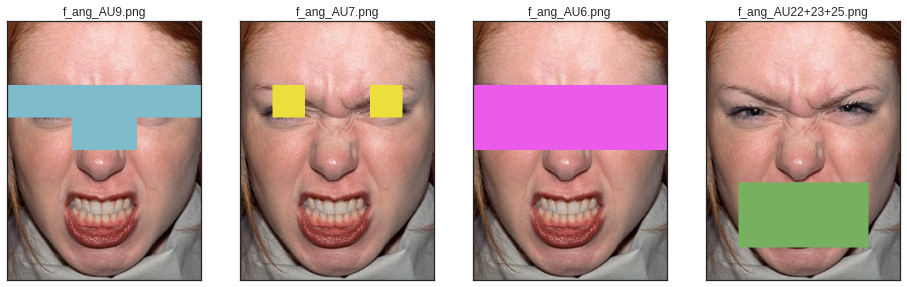

In [23]:
fig = plt.figure(figsize=(16,6))
for i,im in enumerate(imDict):
    ax = plt.subplot( 1, len(imDict.keys()), i+1 )
    ax.set_title(im[im.rfind('/')+1:],fontsize=12)
    ax = plt.imshow(imDict[im])
    plt.xticks([]); plt.yticks([])
plt.show()

### Get all the pictures and their respective AU lists

Here we define a dictionary *picDict*, wich is used to store the filenames of the original image and the AU images for each face.

In [24]:
def makePicDict(picList):
    
    picDict = {}
    for i,ident in enumerate(picList):
        for e,emo in enumerate(picList[i]):
            thisPic = picList[i][e]

            thisName = thisPic[thisPic.find('_')-1:thisPic.rfind('_')]

            myPicList = getFile('../auLabels/',thisName+'*.png')

            picDict[thisName] = {'auList':myPicList,
                                 'picFile':thisPic}
    return picDict

In [25]:
picDict = makePicDict(picList)

In [26]:
picDict

{'f_ang': {'auList': ['../auLabels/f_ang_AU22+23+25.png',
   '../auLabels/f_ang_AU6.png',
   '../auLabels/f_ang_AU7.png',
   '../auLabels/f_ang_AU9.png'],
  'picFile': '../experiment/app/static/img/f_ang_cut.png'},
 'f_dis': {'auList': ['../auLabels/f_dis_AU10+16+19+25+26.png',
   '../auLabels/f_dis_AU4.png',
   '../auLabels/f_dis_AU6.png',
   '../auLabels/f_dis_AU9.png'],
  'picFile': '../experiment/app/static/img/f_dis_cut.png'},
 'f_fea': {'auList': ['../auLabels/f_fea_AU1.png',
   '../auLabels/f_fea_AU2.png',
   '../auLabels/f_fea_AU20+25.png',
   '../auLabels/f_fea_AU5.png'],
  'picFile': '../experiment/app/static/img/f_fea_cut.png'},
 'f_hap': {'auList': ['../auLabels/f_hap_AU12.png',
   '../auLabels/f_hap_AU25.png',
   '../auLabels/f_hap_AU6.png'],
  'picFile': '../experiment/app/static/img/f_hap_cut.png'},
 'f_ntr': {'auList': ['../auLabels/f_ntr_AU25.png'],
  'picFile': '../experiment/app/static/img/f_ntr_cut.png'},
 'f_sad': {'auList': ['../auLabels/f_sad_AU1+4.png',
   '../a

make a list with face names, which is sorted in a nice way, so we can use it for looping

In [27]:
picSort = []
for entry in picList:
    for subentry in entry:
        picSort.append(subentry[subentry.rfind('/')+1:subentry.rfind('_')])
print picSort

['f_hap', 'f_sad', 'f_ang', 'f_fea', 'f_dis', 'f_sup', 'f_ntr', 'm_hap', 'm_sad', 'm_ang', 'm_fea', 'm_dis', 'm_sup', 'm_ntr']


### show all the tile-assignments of action units

In [28]:
picDict[picSort[0]]

{'auList': ['../auLabels/f_hap_AU12.png',
  '../auLabels/f_hap_AU25.png',
  '../auLabels/f_hap_AU6.png'],
 'picFile': '../experiment/app/static/img/f_hap_cut.png'}

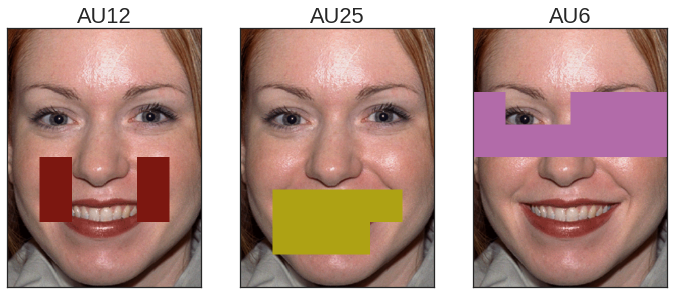

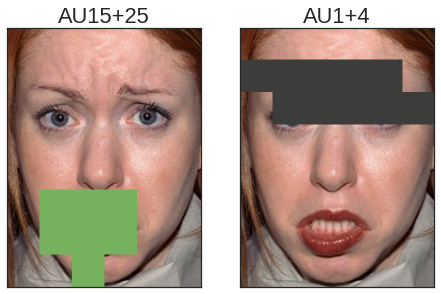

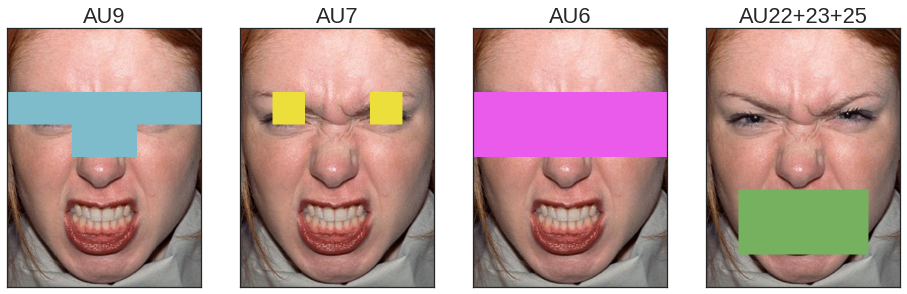

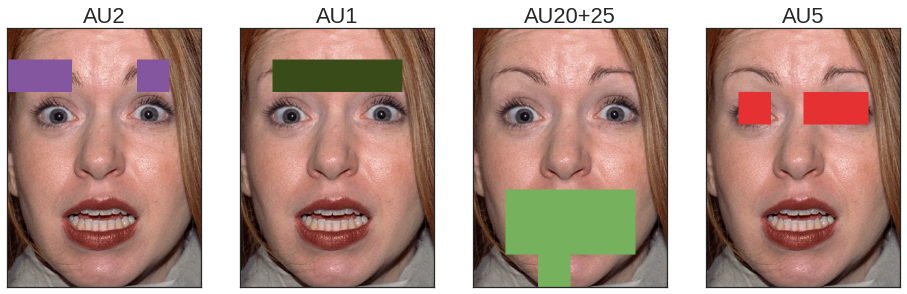

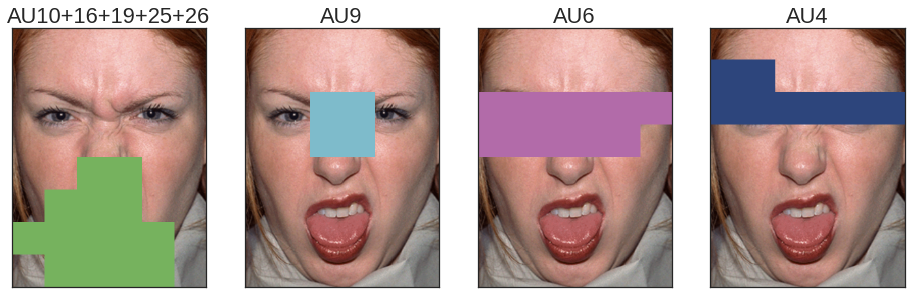

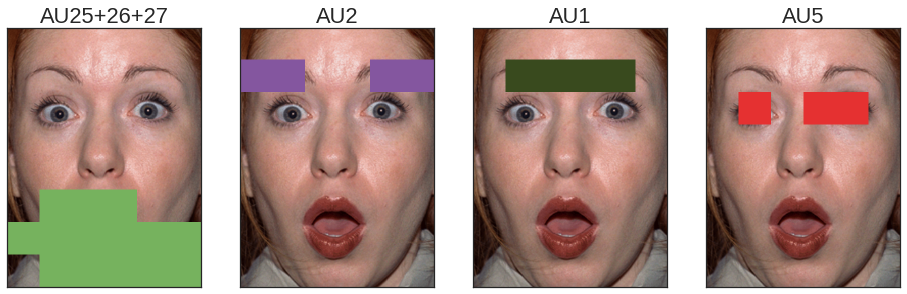

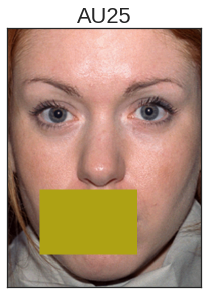

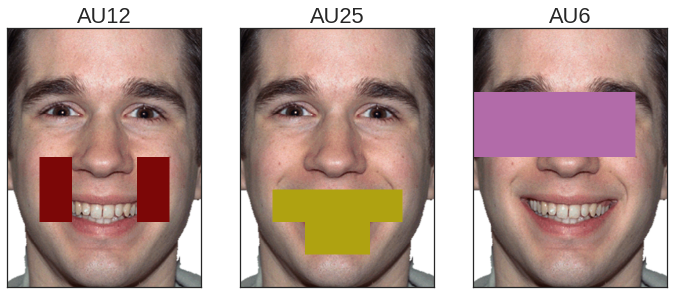

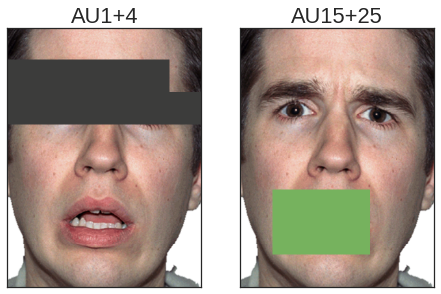

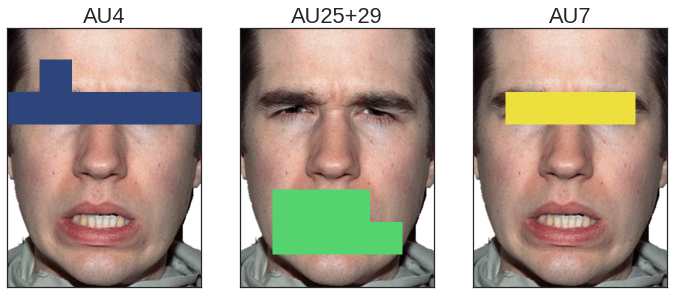

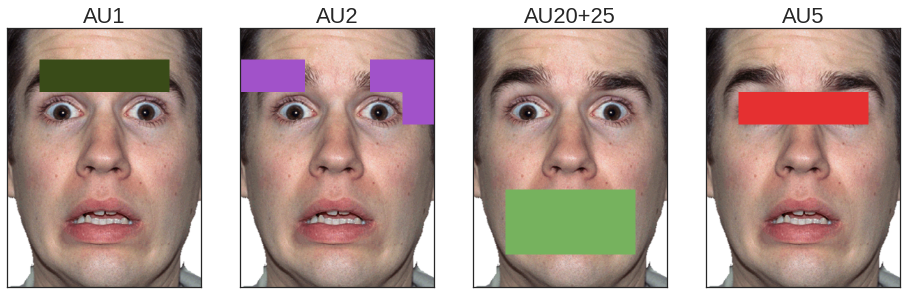

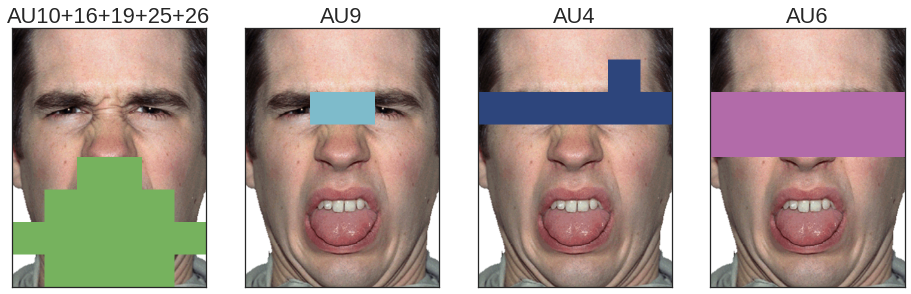

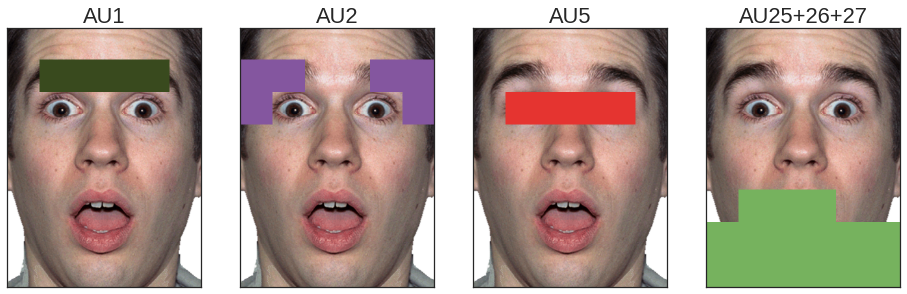

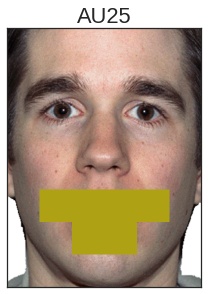

In [29]:
for entry in picSort:
    
    d = makeBinAUs( makeAUTable(picDict[entry]['auList'])).to_dict()
    imDict = showTiles(picDict[entry]['picFile'],d)

    fig = plt.figure(figsize=(16,6))
    for i,im in enumerate(imDict):
        ax = plt.subplot( 1, 4, i+1 )
        imName = im[im.rfind('_')+1:im.rfind('.')]
        ax.set_title(imName)
        ax.set_xticks([]);ax.set_yticks([])
        ax = plt.imshow(imDict[im])
    saveName = '../figures/auAssignments/'+str(im[im.rfind('/')+1:im.rfind('_')])
    plt.savefig(saveName,dpi=300)
    plt.show()

## Derive behavioral metric

These are the acutal behavioral data, which we now want to apply not to single tiles, but to groups of tiles which all belong to the same action unit. The algorithms to derive the values are esentially the same as in the previous notebooks.

In [30]:
metricDf = pd.read_csv('../outputs/weightDf.csv',index_col=[0,1,2])
metricDf.index.names = ['p','ident','emo']
metricDf = metricDf.sortlevel()

In [31]:
metricDf.tail()

0           1           2           3           4  \
p    ident emo                                                               
p096 m     fea -100.000000   17.391304   17.391304  121.739130    4.347826   
           hap    2.595420    9.923664   24.580153   53.893130  -41.374046   
           ntr  290.243902 -100.000000 -100.000000 -100.000000 -100.000000   
           sad -100.000000    1.052632  102.105263 -100.000000 -100.000000   
           sup  -69.953052   12.676056  -17.370892  -69.953052 -100.000000   

                         5           6           7           8           9  \
p    ident emo                                                               
p096 m     fea  121.739130   43.478261   -8.695652 -100.000000 -100.000000   
           hap  -56.030534  -56.030534  -56.030534 -100.000000  -12.061069   
           ntr -100.000000 -100.000000  251.219512 -100.000000  290.243902   
           sad  -24.210526   26.315789  -24.210526  304.210526  102.105263   
           sup -100.000000 -100.000000   27.699531   -9.859155   42.723005   

                        10          11          12          13          14  \
p    ident emo                                                               
p096 m     fea  134.782609    4.347826   30.434783   82.608696  160.869565   
           hap  112.519084   17.251908   61.221374  -63.358779 -100.000000   
           ntr  251.219512 -100.000000  251.219512  641.463415 -100.000000   
           sad -100.000000  127.368421    1.052632 -100.000000 -100.000000   
           sup -100.000000  -24.882629  110.328638 -100.000000  305.633803   

                        15          16          17          18          19  \
p    ident emo                                                               
p096 m     fea -100.000000   -8.695652 -100.000000    4.347826    4.347826   
           hap   68.549618 -100.000000    2.595420   90.534351  -56.030534   
           ntr -100.000000 -100.000000 -100.000000 -100.000000 -100.000000   
           sad -100.000000   26.315789  203.157895   76.842105    1.052632   
           sup   20.187793   57.746479  -69.953052   -2.347418  -17.370892   

                        20          21          22          23          24  \
p    ident emo                                                               
p096 m     fea -100.000000    4.347826  134.782609 -100.000000    4.347826   
           hap   90.534351   75.877863  -63.358779  -56.030534  -92.671756   
           ntr -100.000000 -100.000000 -100.000000 -100.000000 -100.000000   
           sad -100.000000 -100.000000  102.105263 -100.000000  102.105263   
           sup  140.375587  132.863850   87.793427 -100.000000   50.234742   

                        25          26          27          28          29  \
p    ident emo                                                               
p096 m     fea -100.000000  134.782609    4.347826 -100.000000   17.391304   
           hap  134.503817  -26.717557   61.221374  -48.702290  112.519084   
           ntr -100.000000 -100.000000 -100.000000 -100.000000 -100.000000   
           sad  -24.210526  304.210526 -100.000000 -100.000000   26.315789   
           sup   42.723005  -54.929577   20.187793   35.211268  140.375587   

                        30          31          32          33          34  \
p    ident emo                                                               
p096 m     fea   -8.695652   -8.695652   -8.695652   -8.695652  213.043478   
           hap  -85.343511   -4.732824   31.908397  -70.687023   46.564885   
           ntr  290.243902  251.219512 -100.000000 -100.000000 -100.000000   
           sad    1.052632  127.368421 -100.000000  -24.210526    1.052632   
           sup  -47.417840  -54.929577   27.699531 -100.000000   57.746479   

                        35          36          37          38          39  \
p    ident emo                                                               
p096 m     fea   17.391304   -8.695652 -

In [32]:
def getWeight(metricDf,ident,emo,identDict=identDict,emoDict=emoDict):
    outDf = pd.DataFrame()
    for entry in metricDf.index.levels[0]:
        thisDf = pd.DataFrame( metricDf.ix[entry].ix[identDict[ident]].ix[emoDict[emo]] ).T
        thisDf.index = [entry]
        outDf = pd.concat([outDf,thisDf])
    outDf = outDf.sortlevel()
    return outDf

Table of that condition, with all participants

In [33]:
getWeight(metricDf,0,0).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
p001,25.925926,77.777778,-11.111111,-62.962963,-25.925926,-100.000000,107.407407,-33.333333,-100.000000,107.407407,55.555556,-25.925926,40.740741,-40.740741,-62.962963,-48.148148,-3.703704,11.111111,-100.000000,-70.370370,18.518519,77.777778,-70.370370,-70.370370,-33.333333,18.518519,-55.555556,-25.925926,3.703704,18.518519,-55.555556,-92.592593,85.185185,11.111111,40.740741,129.629630,-100.000000,129.629630,-25.925926,85.185185,-25.925926,151.851852,-40.740741,-100.000000,137.037037,-100.000000,18.518519,129.629630
p002,64.928910,64.928910,59.241706,-26.066351,-20.379147,-100.000000,70.616114,-43.127962,-43.127962,30.805687,64.928910,-14.691943,-14.691943,-100.000000,-100.000000,-26.066351,-60.189573,2.369668,-94.312796,-37.440758,8.056872,110.426540,-100.000000,-100.000000,-100.000000,87.677725,-26.066351,36.492891,-20.379147,30.805687,-26.066351,-100.000000,93.364929,30.805687,76.303318,138.862559,-100.000000,47.867299,-20.379147,64.928910,-20.379147,195.734597,-94.312796,-100.000000,81.990521,-94.312796,53.554502,167.298578
p003,-30.012151,-53.341434,39.975699,-100.000000,-70.838396,80.801944,10.814095,-24.179830,39.975699,4.981774,-0.850547,-100.000000,104.131227,4.981774,-82.503038,-0.850547,-41.676792,-100.000000,45.808019,-59.173755,-35.844471,80.801944,28.311057,-47.509113,-18.347509,-53.341434,150.789793,-76.670717,-70.838396,104.131227,45.808019,39.975699,74.969623,-47.509113,109.963548,255.771567,-30.012151,-30.012151,-53.341434,-30.012151,-30.012151,-47.509113,4.981774,-47.509113,-35.844471,57.472661,-76.670717,109.963548
p004,-2.040816,-91.836735,-91.836735,-51.020408,-34.693878,144.897959,95.918367,-100.000000,-26.530612,6.122449,-42.857143,210.204082,22.448980,185.714286,14.285714,14.285714,38.775510,-100.000000,-51.020408,-100.000000,-100.000000,120.408163,-91.836735,14.285714,-34.693878,-100.000000,169.387755,-100.000000,6.122449,357.142857,-18.367347,-34.693878,-51.020408,14.285714,22.448980,63.265306,-26.530612,79.591837,46.938776,-26.530612,6.122449,-34.693878,-34.693878,-91.836735,-100.000000,-42.857143,46.938776,-100.000000
p005,290.921228,-10.280374,8.945260,-61.548732,-29.506008,8.945260,53.805073,-48.731642,8.945260,-10.280374,8.945260,-29.506008,85.847797,21.762350,-67.957276,-29.506008,-23.097463,-16.688919,-61.548732,28.170895,-55.140187,-100.000000,60.213618,-93.591455,15.353805,-100.000000,85.847797,53.805073,-67.957276,233.244326,-48.731642,8.945260,28.170895,-16.688919,105.073431,-42.323097,-42.323097,98.664887,-100.000000,-100.000000,-48.731642,-16.688919,15.353805,8.945260,-55.140187,-48.731642,8.945260,85.847797


## Combining The AU assigments and the tile metrics

In [34]:
def writeMetric(metricDf,facePic,p,picDict=picDict,thisCoord=thisCoord):
    
    # names of action units 
    auList = picDict[facePic]['auList'] 

    # transforming the coordinates to indices from 0 to 47
    cCodes = {}
    for c,coord in enumerate(thisCoord):
        cCodes[ c ] = coord
    
    # dict to write to
    auDict = {float(np.nan):[]}
    
    # tracker for tiles belonging to no au
    notNan = []
    
    for au in auList:
        
        auDict[au] = []
        
        # mapping of coordinates to AUs
        d = makeBinAUs( makeAUTable(auList) ).to_dict()
        
        # looping through the metrics
        for key in metricDf.ix[p].to_dict():
            thisCoord = d[au][cCodes[int(key)]]
            # get the metric
            thisMetric = metricDf.ix[p].to_dict()[key]
            if d[au][tuple(cCodes[int(key)])] == 1:
                # adding value to 
                auDict[au].append( thisMetric)
                
                # keep track that this is not a nan
                notNan.append(key)

    # do that for the remaining nans
    for key in metricDf.ix[p].to_dict():
        if key not in notNan:
            thisCoord = d[au][cCodes[int(key)]]
            # get the metric
            thisMetric = metricDf.ix[p].to_dict()[key]
            # adding value to 
            auDict[float(np.nan)].append( thisMetric)

    # transform to df
    auDf = pd.DataFrame(index=[p])

    for entry in auDict:
        auDf[entry] = np.mean(auDict[entry])

    # cleaning up columns names
    cleanCols = []
    for e in auDf.columns:
        if type(e) == str:
            cleanCols.append(e[e.rfind('_')+1:e.rfind('.')] )
        else:
            cleanCols.append(e)

    auDf.columns = cleanCols
    return auDf

Example:

In [35]:
writeMetric( getWeight(metricDf,0,3),
            'f_fea',
            'p001'
           )

,nan,AU2,AU1,AU20+25,AU5
p001,-10.003494,-1.805054,-26.353791,15.523466,125.270758


### Do this for all participants

In [36]:
def writeAllMetrics(metricDf,ident,emo,picList=picList,picDict=picDict):

    facePic = picList[ident][emo]
    faceName = facePic[facePic.rfind('/')+1:facePic.rfind('_')]
    thisMetric = getWeight(metricDf,ident,emo)

    bigDf = pd.DataFrame()
    for p in thisMetric.index:
        thisDf = writeMetric(thisMetric,faceName,p,picDict=picDict)
        bigDf = pd.concat([bigDf,thisDf])
    
    return bigDf,faceName

Example: fearful female face (0,3)

In [37]:
fFeaDf,dummy = writeAllMetrics(metricDf,0,3)

In [38]:
fFeaDf.head()

,nan,AU2,AU1,AU20+25,AU5
p001,-10.003494,-1.805054,-26.353791,15.523466,125.270758
p002,-9.201378,-3.689320,-13.786408,-3.689320,157.864078
p003,-11.520737,37.142857,105.714286,-46.666667,151.428571
p004,-11.966701,-22.580645,16.129032,56.989247,-35.483871
p005,-4.403927,-30.434783,-47.826087,6.666667,53.043478


### Do this for all faces

In [39]:
def writeAllFaces(metricDf,picList=picList,picDict=picDict):
    bigDf = pd.DataFrame()
    for ident in range(2):
        for emo in range(7):
            thisDf,faceName = writeAllMetrics(metricDf,ident,emo,picList=picList,picDict=picDict)
            thisDf.columns = [ [faceName]*len(thisDf.columns),thisDf.columns]
            bigDf = pd.concat([bigDf,thisDf],axis=1)
    return bigDf

In [40]:
bigAU = writeAllFaces(metricDf)

In [41]:
bigAU.head()

f_hap                                       f_sad             \
            NaN       AU12       AU25        AU6        NaN    AU15+25   
p001   9.833972   7.407407  -0.529101 -22.222222 -19.420671  -2.040816   
p002   8.252983 -41.706161 -19.566689   1.232227 -19.782355   1.204819   
p003 -13.922990  12.272175  21.645548  17.812880  -6.571087  -8.994709   
p004 -22.026742  65.306122  92.419825  -0.408163  -9.136566  43.712575   
p005 -14.258091  40.987984  28.170895  17.276368  19.106700   5.494505   

                     f_ang                                              \
          AU1+4        NaN        AU9        AU7        AU6 AU22+23+25   
p001  61.632653 -19.467061  34.715026  -8.808290  36.096718  13.989637   
p002  60.481928 -37.074247  68.782161  -9.433962  65.351630  31.732419   
p003  26.666667 -28.035105  21.843003  -1.706485  22.866894  63.822526   
p004  -2.275449  -8.777084  -2.056555  57.326478   7.969152  18.766067   
p005 -63.076923  -3.970528 -33.810888 -34.670487 -23.209169  48.710602   

          f_fea                                                    f_dis  \
            NaN        AU2         AU1    AU20+25         AU5        NaN   
p001 -10.003494  -1.805054  -26.353791  15.523466  125.270758 -25.658807   
p002  -9.201378  -3.689320  -13.786408  -3.689320  157.864078 -41.200828   
p003 -11.520737  37.142857  105.714286 -46.666667  151.428571 -43.111111   
p004 -11.966701 -22.580645   16.129032  56.989247  -35.483871 -33.445378   
p005  -4.403927 -30.434783  -47.826087   6.666667   53.043478 -14.235145   

                                                             f_sup             \
     AU10+16+19+25+26         AU9        AU6        AU4        NaN        AU2   
p001        50.346741  -49.514563 -14.563107  25.242718   0.651982 -15.418502   
p002        75.155280 -100.000000 -39.920949  30.434783   9.136842 -46.947368   
p003        49.333333   -4.000000  37.696970   4.000000 -14.233503  -0.507614   
p004        49.747899  -36.470588  -1.176471  -2.941176 -22.292467  13.441654   
p005        50.493047  -21.415929 -28.173773 -40.530973 -17.338552  64.383562   

                                           f_ntr                 m_hap  \
            AU1 AU25+26+27        AU5        NaN       AU25        NaN   
p001 -25.991189  14.285714 -64.757709  -2.699869  18.899083 -21.095890   
p002 -64.631579  11.157895 -36.000000  -3.454715  24.183007 -24.236760   
p003  11.675127  10.224801  48.900169 -10.379165  72.654155   1.768707   
p004  27.621861  33.192657 -14.918759   7.711757 -53.982301  -7.976879   
p005  62.035225  20.771596 -46.771037   0.348432  -2.439024   0.295791   

                                           m_sad                         \
           AU12       AU25        AU6        NaN      AU1+4     AU15+25   
p001 -59.817352  57.077626  37.351598        NaN        NaN         NaN   
p002 -43.925234  79.439252  30.841121 -14.590747  61.501132  -37.366548   
p003  78.231293  35.147392 -29.251701   3.225806 -27.272727   33.333333   
p004 -16.763006  19.075145   8.208092        NaN        NaN         NaN   
p005 -24.914676  11.035267  -0.068259 -15.542522 -20.661157  118.181818   

          m_ang                                        m_fea             \
            NaN    AU25+29         AU7        AU4        NaN        AU1   
p001        NaN        NaN         NaN        NaN  17.679888  17.919075   
p002  -6.348282  -6.647808   33.663366  37.482320   5.747126  64.705882   
p003 -19.191919  26.984127   85.858586  66.233766  12.551724  63.200000   
p004 -20.204604  26.708075  173.913043  71.428571  -3.532896 -70.552147   
p005 -13.459621  14.285714   69.491525  51.089588 -27.893479  60.396040   

                                            m_dis                              \
            AU2    AU20+25         AU5        NaN AU10+16+19+25+26        AU4   
p001 -22.312139 -20.231214  -44.508671  13.506301         3.943662 -58.470825   
p002  12.941176 -30.392157    7.843137   3.711911        

### Taking the nan (no Action Unit) as baseline

In [42]:
def baselineCorrection(df,cond):
    # select the condition
    thisCorr = df[cond]
    diffDf = pd.DataFrame()

    # for all action units
    for actionUnit in thisCorr.columns:
        # we subtract the baseline
        thisDiff = thisCorr[actionUnit]-thisCorr[np.nan]
        diffDf[actionUnit] = thisDiff
    diffDf = diffDf.drop(np.nan,axis=1)
    
    # restore the original structure of the multicolumns
    diffDf.columns = [[cond]*len(diffDf.columns),diffDf.columns]
    
    return diffDf

Example:

In [43]:
bigAU['f_fea'].head()

,nan,AU2,AU1,AU20+25,AU5
p001,-10.003494,-1.805054,-26.353791,15.523466,125.270758
p002,-9.201378,-3.689320,-13.786408,-3.689320,157.864078
p003,-11.520737,37.142857,105.714286,-46.666667,151.428571
p004,-11.966701,-22.580645,16.129032,56.989247,-35.483871
p005,-4.403927,-30.434783,-47.826087,6.666667,53.043478


In [44]:
baselineCorrection(bigAU,'f_fea').head()


f_fea                                   
            AU2         AU1    AU20+25         AU5
p001   8.198440  -16.350297  25.526959  135.274252
p002   5.512058   -4.585030   5.512058  167.065456
p003  48.663594  117.235023 -35.145929  162.949309
p004 -10.613944   28.095734  68.955949  -23.517170
p005 -26.030856  -43.422160  11.070594   57.447405

###  Do this for the whole big table

In [45]:
def makeBaseline(bigAU):
    baselineDf = pd.DataFrame()
    for face in bigAU.columns.levels[0]:
        thisDf = baselineCorrection(bigAU,face)
        baselineDf = pd.concat([baselineDf,thisDf],axis=1)
    
    return baselineDf

In [46]:
baselineDf = makeBaseline(bigAU)

Example:

In [47]:
baselineDf['f_fea'].head()

,AU2,AU1,AU20+25,AU5
p001,8.198440,-16.350297,25.526959,135.274252
p002,5.512058,-4.585030,5.512058,167.065456
p003,48.663594,117.235023,-35.145929,162.949309
p004,-10.613944,28.095734,68.955949,-23.517170
p005,-26.030856,-43.422160,11.070594,57.447405


In [48]:
baselineDf.to_csv('../outputs/actionUnitTable.csv')

### Example of re-loading

In [49]:
baselineDf = pd.read_csv('../outputs/actionUnitTable.csv',index_col=[0],header=[0,1])

In [50]:
baselineDf.head()

f_ang                                              f_dis  \
             AU9        AU7         AU6 AU22+23+25 AU10+16+19+25+26   
p001   54.182087  10.658771   55.563780  33.456699        76.005548   
p002  105.856408  27.640284  102.425876  68.806665       116.356108   
p003   49.878108  26.328620   50.901999  91.857630        92.444444   
p004    6.720529  66.103562   16.746236  27.543151        83.193277   
p005  -29.840360 -30.699959  -19.238641  52.681130        64.728192   

                                           f_fea                         \
            AU9        AU6        AU4        AU2         AU1    AU20+25   
p001 -23.855756  11.095700  50.901526   8.198440  -16.350297  25.526959   
p002 -58.799172   1.279880  71.635611   5.512058   -4.585030   5.512058   
p003  39.111111  80.808081  47.111111  48.663594  117.235023 -35.145929   
p004  -3.025210  32.268908  30.504202 -10.613944   28.095734  68.955949   
p005  -7.180784 -13.938628 -26.295828 -26.030856  -43.422160  11.070594   

                      f_hap                             f_ntr      f_sad  \
             AU5       AU12        AU25        AU6       AU25    AU15+25   
p001  135.274252  -2.426564  -10.363072 -32.056194  21.598952  17.379855   
p002  167.065456 -49.959144  -27.819672  -7.020755  27.637722  20.987175   
p003  162.949309  26.195165   35.568538  31.735870  83.033321  -2.423622   
p004  -23.517170  87.332864  114.446567  21.618578 -61.694058  52.849140   
p005   57.447405  55.246075   42.428986  31.534460  -2.787456 -13.612194   

                     f_sup                                       m_ang  \
          AU1+4        AU2        AU1 AU25+26+27        AU5    AU25+29   
p001  81.053325 -16.070485 -26.643172  13.633732 -65.409692        NaN   
p002  80.264283 -56.084211 -73.768421   2.021053 -45.136842  -0.299526   
p003  33.237754  13.725888  25.908629  24.458303  63.133672  46.176046   
p004   6.861116  35.734121  49.914328  55.485123   7.373708  46.912678   
p005 -82.183623  81.722114  79.373777  38.110148 -29.432485  27.745335   

                                       m_dis                        \
             AU7        AU4 AU10+16+19+25+26        AU4        AU6   
p001         NaN        NaN        -9.562639 -71.977126 -31.816160   
p002   40.011648  43.830602        28.288089 -87.832212 -43.922438   
p003  105.050505  85.425685       -15.965191  52.442713  12.015731   
p004  194.117647  91.633175       -22.938985   2.661521   2.577240   
p005   82.951147  64.549210        26.022137 -38.723418 -19.471425   

                      m_fea                                        m_hap  \
             AU9        AU1        AU2    AU20+25         AU5       AU12   
p001  -42.520385   0.239187 -39.992027 -37.911102  -62.188559 -38.721461   
p002 -103.711911  58.958756   7.194050 -36.139283    2.096011 -19.688474   
p003  -14.057401  50.648276 -58.791724 -35.751724  -54.951724  76.462585   
p004    3.167210 -67.019251 -49.350539  32.367252   72.858050  -8.786127   
p005  -46.080867  88.289519  46.705360  34.824172  135.814271 -25.210466   

                                 m_ntr      m_sad                   m_sup  \
            AU25        AU6       AU25      AU1+4     AU15+25         AU1   
p001   78.173516  58.447489  46.664338        NaN         NaN -100.183621   
p002  103.676012  55.077882  20.564686  76.091880  -22.775801  -79.853480   
p003   33.378685 -31.020408  75.261324 -30.498534   30.107527    5.479452   
p004   27.052023  16.184971  47.840532        NaN         NaN    0.427503   
p005   10.739477  -0.364050  47.573479  -5.118635  133.724340  115.853659   

                                       
            AU2        AU5 AU25+26+27  
p001 -71.391847  44.803526 -32.317297  
p002 -62.759463 -51.648352 -37.118437  
p003  23.287671  36.301370  80.000000  
p004 -20.520128  15.390096  -4.560029  
p005  56.097561 -52.439024  38.048780

## Basic plotting

In [51]:
def makeActionUnitPlot(baselineDf,face):
    # select the face condition
    thisDf = baselineDf[face]
    
    colNames = thisDf.columns
    # get number of participants (with values)
    n = int(thisDf.describe().ix['count'][-1])
    
    # get all metrics into a df which we sort descending
    plotDf = pd.DataFrame()
    plotDf['mean'] = thisDf.mean()
    #print float( thisDf.mean() ), float( thisDf.describe().ix['mean'] )
    plotDf['ci'] = thisDf.std()/np.sqrt(n)*1.96
 
    plotDf['color'] = [rgb2hex(getColor('../auLabels/'+face+'_'+colName+'.png')) for colName in colNames]
    plotDf = plotDf.sort_values(by="mean",ascending=False)
   
    # plot this bar at the correct position and using the correct color
    # this is done in a 
    plt.xticks(np.arange(len(plotDf.index))+0.45,plotDf.index,rotation=45)
    plt.xlim(-0.05,4.05)
    plt.yticks(range(0,101,20),['0%','20%','40%','60%','80%','100%'])
    plt.ylim(-10,100)
    plt.axhline(0,color='k')
    plt.title(face,fontsize=20)
    im = plt.bar(range(len(plotDf.index)) ,
            plotDf['mean'],
            yerr=plotDf['ci'],
            color= plotDf['color'],
            ecolor='k')
    
    return im

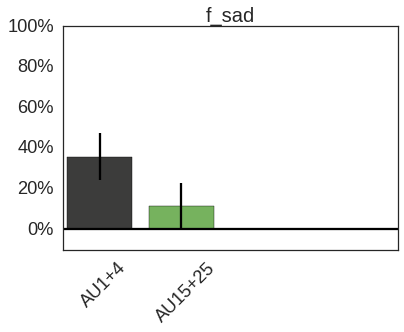

In [52]:
makeActionUnitPlot(baselineDf,'f_sad');

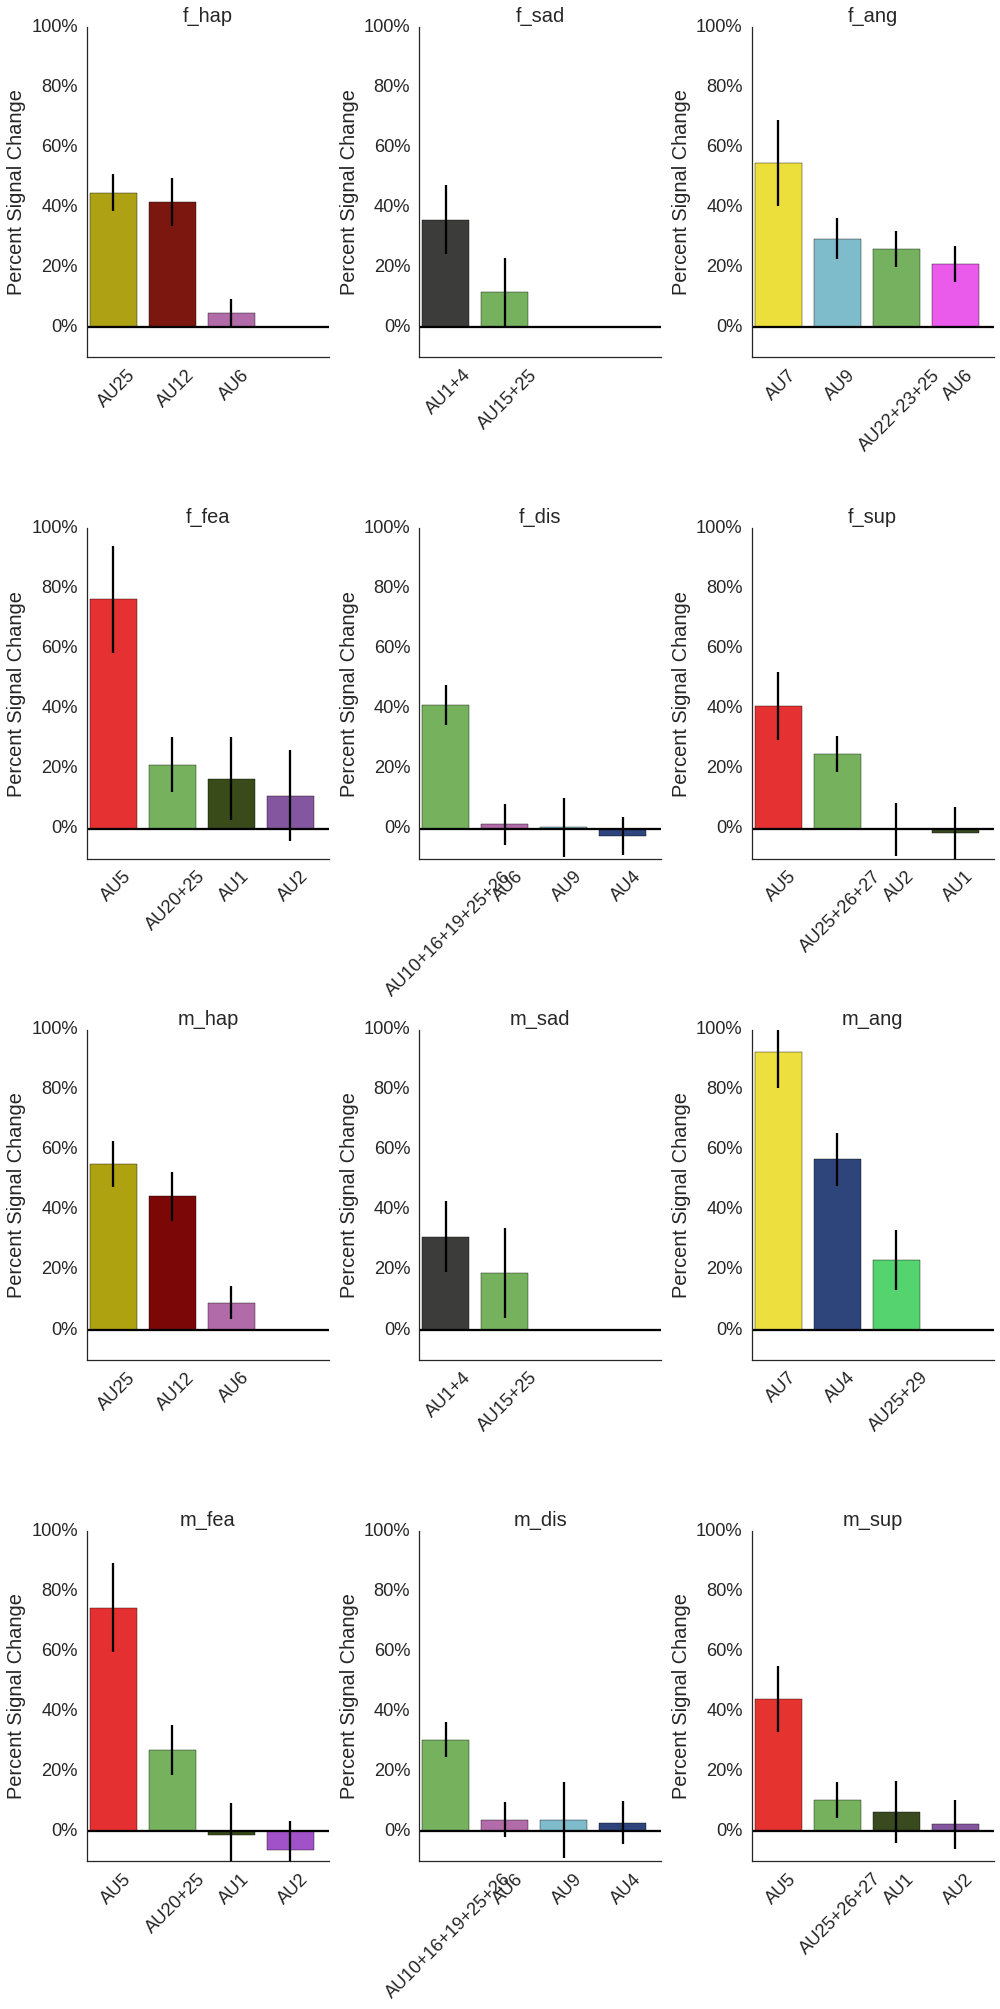

In [53]:
fig = plt.figure(figsize=(14,28))
count = 1
for pic in picSort:
    if 'ntr' not in pic:
        ax = plt.subplot(4,3,count)
        ax = makeActionUnitPlot(baselineDf,pic)
        plt.ylabel('Percent Signal Change')
        count+=1
        sns.despine()
plt.tight_layout()
plt.savefig('../figures/allAUs.png',dpi=300)
plt.show()

# 4b. Plotting Results by Face Half

This basically re-uses the scripts above, but there are only two regions and together they make up the whole face. Therfore, a difference score can be computed which summarizes for each face whether the upper face half (positive values) or the lower face half (negative values) is more important.

### get the up/low mask images

In [54]:
myPicList = getFile('../auLabels/','*er.png')

In [55]:
myPicList

['../auLabels/lower.png', '../auLabels/upper.png']

### assign tiles to upper/lower half

In [56]:
makeBinAUs( makeAUTable(myPicList) ).head()

../auLabels/lower.png  ../auLabels/upper.png
0 0                        0                      1
  50                       0                      1
  100                      0                      1
  150                      0                      1
  200                      1                      0

In [57]:
d = makeBinAUs( makeAUTable(myPicList) ).to_dict()

### here, each face has the same two masks

In [58]:
def makePicDict(picList,myPicList):
    
    picDict = {}
    for i,ident in enumerate(picList):
        for e,emo in enumerate(picList[i]):
            thisPic = picList[i][e]

            thisName = thisPic[thisPic.find('_')-1:thisPic.rfind('_')]

            picDict[thisName] = {'auList':myPicList,
                                 'picFile':thisPic}
    return picDict

In [59]:
picDict = makePicDict(picList,myPicList)

In [60]:
picDict

{'f_ang': {'auList': ['../auLabels/lower.png', '../auLabels/upper.png'],
  'picFile': '../experiment/app/static/img/f_ang_cut.png'},
 'f_dis': {'auList': ['../auLabels/lower.png', '../auLabels/upper.png'],
  'picFile': '../experiment/app/static/img/f_dis_cut.png'},
 'f_fea': {'auList': ['../auLabels/lower.png', '../auLabels/upper.png'],
  'picFile': '../experiment/app/static/img/f_fea_cut.png'},
 'f_hap': {'auList': ['../auLabels/lower.png', '../auLabels/upper.png'],
  'picFile': '../experiment/app/static/img/f_hap_cut.png'},
 'f_ntr': {'auList': ['../auLabels/lower.png', '../auLabels/upper.png'],
  'picFile': '../experiment/app/static/img/f_ntr_cut.png'},
 'f_sad': {'auList': ['../auLabels/lower.png', '../auLabels/upper.png'],
  'picFile': '../experiment/app/static/img/f_sad_cut.png'},
 'f_sup': {'auList': ['../auLabels/lower.png', '../auLabels/upper.png'],
  'picFile': '../experiment/app/static/img/f_sup_cut.png'},
 'm_ang': {'auList': ['../auLabels/lower.png', '../auLabels/upper.png

### illustrate the masking

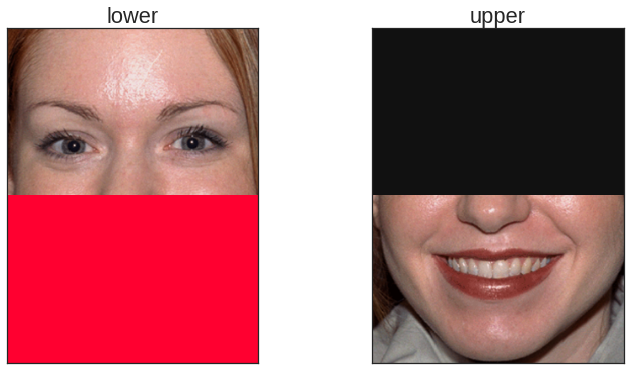

In [61]:
for entry in picSort:
    
    d = makeBinAUs( makeAUTable(picDict[entry]['auList'])).to_dict()
    imDict = showTiles(picDict[entry]['picFile'],d)

    fig = plt.figure(figsize=(12,6))
    for i,im in enumerate(imDict):
        ax = plt.subplot( 1, 2, i+1 )
        imName = im[im.rfind('_')+1:im.rfind('.')]
        ax.set_title(imName[imName.rfind('/')+1:])
        ax.set_xticks([]);ax.set_yticks([])
        ax = plt.imshow(imDict[im])

    plt.savefig('../figures/auAssignments/upDownExample.png',dpi=300)
    plt.show()
    break # do this only for the first image

### get the metric for each half

Here, there is no nan, because each tile must belong to one of the two masks

Example:

In [62]:
writeMetric( getWeight(metricDf,0,3),
            'f_fea',
            'p001',
            picDict=picDict
           )

/opt/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


,nan,../auLabels/lower,../auLabels/upper
p001,NaN,-1.805054,1.805054


### get the metric for all faces and all participants

In [63]:
bigUpperLower = writeAllFaces(metricDf,picDict=picDict)

In [64]:
bigUpperLower.head()

f_hap                                     f_sad                    \
       NaN ../auLabels/lower ../auLabels/upper   NaN ../auLabels/lower   
p001   NaN         -2.469136          2.469136   NaN         -9.523810   
p002   NaN        -13.744076         13.744076   NaN         -7.228916   
p003   NaN          3.280680         -3.280680   NaN         -2.469136   
p004   NaN         19.727891        -19.727891   NaN         -5.988024   
p005   NaN         -9.212283          9.212283   NaN        -38.461538   

                       f_ang                                     f_fea  \
     ../auLabels/upper   NaN ../auLabels/lower ../auLabels/upper   NaN   
p001          9.523810   NaN          5.699482         -5.699482   NaN   
p002          7.228916   NaN          7.718696         -7.718696   NaN   
p003          2.469136   NaN          9.215017         -9.215017   NaN   
p004          5.988024   NaN          1.028278         -1.028278   NaN   
p005         38.461538   NaN          5.157593         -5.157593   NaN   

                                         f_dis                    \
     ../auLabels/lower ../auLabels/upper   NaN ../auLabels/lower   
p001         -1.805054          1.805054   NaN         14.886731   
p002          7.961165         -7.961165   NaN         28.260870   
p003          2.857143         -2.857143   NaN         16.444444   
p004         14.516129        -14.516129   NaN         10.294118   
p005        -30.434783         30.434783   NaN         21.769912   

                       f_sup                                     f_ntr  \
     ../auLabels/upper   NaN ../auLabels/lower ../auLabels/upper   NaN   
p001        -14.886731   NaN          7.488987         -7.488987   NaN   
p002        -28.260870   NaN          7.789474         -7.789474   NaN   
p003        -16.444444   NaN          8.967851         -8.967851   NaN   
p004        -10.294118   NaN         14.918759        -14.918759   NaN   
p005        -21.769912   NaN          8.806262         -8.806262   NaN   

                                         m_hap                    \
     ../auLabels/lower ../auLabels/upper   NaN ../auLabels/lower   
p001         -4.954128          4.954128   NaN         -8.675799   
p002          5.555556         -5.555556   NaN         -2.180685   
p003          6.970509         -6.970509   NaN          2.947846   
p004        -13.274336         13.274336   NaN         19.653179   
p005        -12.195122         12.195122   NaN         -5.119454   

                       m_sad                                     m_ang  \
     ../auLabels/upper   NaN ../auLabels/lower ../auLabels/upper   NaN   
p001          8.675799   NaN               NaN               NaN   NaN   
p002          2.180685   NaN        -25.266904         25.266904   NaN   
p003         -2.947846   NaN         33.333333        -33.333333   NaN   
p004        -19.653179   NaN               NaN               NaN   NaN   
p005          5.119454   NaN        -27.272727         27.272727   NaN   

                                         m_fea                    \
     ../auLabels/lower ../auLabels/upper   NaN ../auLabels/lower   
p001               NaN               NaN   NaN        -17.919075   
p002          3.465347         -3.465347   NaN        -15.359477   
p003         13.131313        -13.131313   NaN        -20.000000   
p004        -10.144928         10.144928   NaN          0.613497   
p005          9.039548         -9.039548   NaN        -16.831683   

                       m_dis                                     m_sup  \
     ../auLabels/upper   NaN ../auLabels/lower ../auLabels/upper   NaN   
p001         17.919075   NaN          7.323944         -7.323944   NaN   
p002         15.359477   NaN         22.105263        -22.105263   NaN   
p003         20.000000   NaN        -12.559618         12.559618   NaN   
p004         -0.613497   NaN        -14.749263         14.749263   NaN   
p005         16.831683   NaN          4.291845        

### compute a difference score up minus down

In [77]:
def makeDiffDf(bigUpperLower):
    bigDiff = pd.DataFrame()
    for entry in bigUpperLower.columns.levels[0]:
        thisDiff = pd.DataFrame( bigUpperLower[entry]['../auLabels/upper']- bigUpperLower[entry]['../auLabels/lower'] )
        thisDiff.columns = [ [entry[0]] , [entry[2:]] ]
        bigDiff = pd.concat([bigDiff,thisDiff],axis=1)
    return bigDiff

In [78]:
bigDiff = makeDiffDf(bigUpperLower)

Example:

In [79]:
bigDiff.head()

f                                                         \
            ang        dis        fea        hap        ntr        sad   
p001 -11.398964 -29.773463   3.610108   4.938272   9.908257  19.047619   
p002 -15.437393 -56.521739 -15.922330  27.488152 -11.111111  14.457831   
p003 -18.430034 -32.888889  -5.714286  -6.561361 -13.941019   4.938272   
p004  -2.056555 -20.588235 -29.032258 -39.455782  26.548673  11.976048   
p005 -10.315186 -43.539823  60.869565  18.424566  24.390244  76.923077   

                         m                                              \
            sup        ang        dis        fea        hap        ntr   
p001 -14.977974        NaN -14.647887  35.838150  17.351598  -7.334963   
p002 -15.578947  -6.930693 -44.210526  30.718954   4.361371  30.088496   
p003 -17.935702 -26.262626  25.119237  40.000000  -5.895692 -30.894309   
p004 -29.837518  20.289855  29.498525  -1.226994 -39.306358  10.465116   
p005 -17.612524 -18.079096  -8.583691  33.663366  10.238908 -46.889952   

                            
            sad        sup  
p001        NaN   9.768638  
p002  50.533808   2.564103  
p003 -66.666667 -32.876712  
p004        NaN -21.446384  
p005  54.545455  -9.756098

## Make a figure

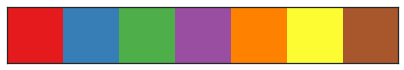

In [80]:
sns.set_style('white')
sns.palplot(stackColors)

In [81]:
def makeUpLowPlot(bigDiff,emoReverse=emoReverse,stackColors=stackColors):
    fig = plt.figure(figsize=(16,6))
    ax = plt.subplot(1,2,1)
    # hard-code the order to please us
    myOrder=['dis','sup','hap','ang','ntr','fea','sad']
    for e,entry in enumerate(myOrder):
        thisCond = bigDiff['f'][entry]

        ax.bar([e],
                 thisCond.mean(),
                 color=stackColors[emoReverse[entry]],
                 yerr=thisCond.std()/np.sqrt(len(thisCond))*1.96,
                 ecolor='k'
                )
    ax.set_xlim(-0.1,7.1)
    ax.set_xticks(np.arange(len(myOrder))+0.4)
    ax.set_xticklabels(myOrder );
    ax.axhline(0,color='k')
    ax.set_ylabel('Upper-Lower % Difference')
    ax.set_xlabel('emotion expression')
    ax.set_title('Female Face')
    ax.set_ylim(-33,30)
    sns.despine()

    ax = plt.subplot(1,2,2)
    myOrder=['dis','hap','ntr','sup','fea','sad','ang']
    for e,entry in enumerate(myOrder):
        thisCond = bigDiff['m'][entry]

        ax.bar([e],
                 thisCond.mean(),
                 color=stackColors[emoReverse[entry]],
                 yerr=thisCond.std()/np.sqrt(len(thisCond))*1.96,
                 ecolor='k'
                )
    ax.set_xlim(-0.1,7.1)
    ax.set_xticks(np.arange(len(myOrder))+0.4)
    ax.set_xticklabels(myOrder );
    ax.axhline(0,color='k')
    ax.set_ylabel('Upper-Lower % Difference')
    ax.set_xlabel('emotion expression')
    ax.set_title('Male Face')
    ax.set_ylim(-33,30)
    sns.despine()
    
    plt.savefig('../figures/upDownPlot.png',dpi=300)
    plt.show()

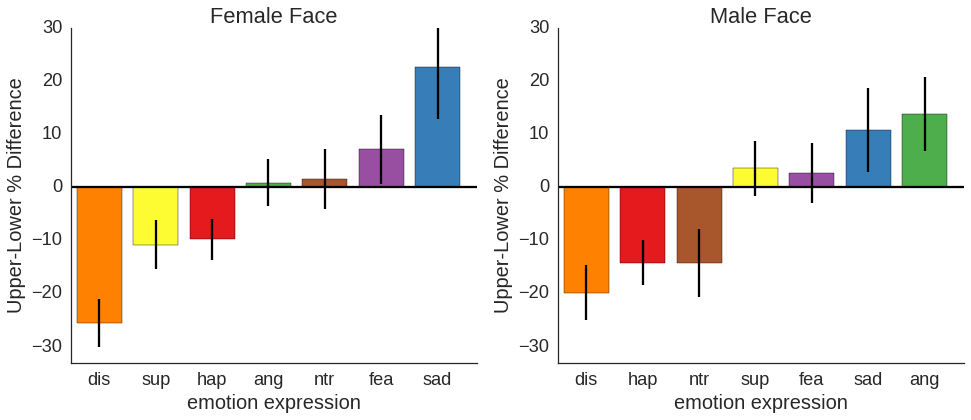

In [82]:
makeUpLowPlot(bigDiff)